---
# **Disaster tweets or not disaster tweets NLP project**
---




```
# Project prepared by Stephanie Cotineau - #dsmpt-Paris-08
```



In [1]:
# Import librairies

from google.colab import files
import pandas as pd
import io

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [2]:
!pip install spacy -q

In [3]:
!python -m spacy download en_core_web_sm -q

     |████████████████████████████████| 12.8 MB 4.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import re

from sklearn.utils import shuffle

from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, SimpleRNN, GRU, LSTM
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.optimizers import Adam

## > Import Train data & Test data

---

In [5]:
# Select file where to upload train data

data_to_load = files.upload()

Saving train.csv to train.csv


In [6]:
# Import train data

train = pd.read_csv(io.BytesIO(data_to_load['train.csv']))

In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# Select file where to upload train data

data_to_load = files.upload()

Saving test.csv to test.csv


In [9]:
# Import test data

test = pd.read_csv(io.BytesIO(data_to_load['test.csv']))

In [10]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# **Train dataset's preprocessing and data cleaning**

---


## > Undersampling to get balanced Train's "target" & drop useless columns
---

In [11]:
# Number of observation per target

train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [12]:
new_train0=train[train['target']==0]
new_train1=train[train['target']==1]

In [13]:
new_train1.shape

(3271, 5)

In [14]:
new_train0.shape

(4342, 5)

In [15]:
# Generating randomly train target 0 sample with same size/number of observations of train target 1

new_train0=new_train0.sample(new_train1.shape[0]) 
new_train0.shape

(3271, 5)

In [16]:
# Aggregating balanced targets in new train dataframe 

new_train=pd.concat([new_train0,new_train1],axis=0)

In [17]:
# Shuffle lines/values of new_train dataset
   
new_train = shuffle(new_train)

In [18]:
new_train

,id,keyword,location,text,target
4740,6742,lava,USA,Check This Deal : http://t.co/uOoYgBb6aZ Sivan...,0
7061,10115,upheaval,USA,Newberg upheaval: Jacque Betz responds 'lookin...,0
3714,5282,fear,Midwestern USA,@CowgirlLawyer We must refuse to become a nati...,1
2173,3116,debris,NaN,RÌ©union Debris Is Almost Surely From Flight 3...,1
711,1026,blazing,"Pennsylvania, PA",I still don't know how 8 hours of physical act...,0
...,...,...,...,...,...
4399,6255,hijacking,EastCarolina,#hot Funtenna: hijacking computers to send da...,0
5618,8016,refugees,paradise,#retweet Cameroon repatriating about 12000 Nig...,1
2658,3819,detonate,Colorado,@BldrCOSheriff says 2nd grenade found is 'youn...,1
7207,10323,weapon,"Manchester, England",'Education is the most powerful weapon which y...,0


In [19]:
new_train=new_train.reset_index(drop=True)

In [20]:
new_train

,id,keyword,location,text,target
0,6742,lava,USA,Check This Deal : http://t.co/uOoYgBb6aZ Sivan...,0
1,10115,upheaval,USA,Newberg upheaval: Jacque Betz responds 'lookin...,0
2,5282,fear,Midwestern USA,@CowgirlLawyer We must refuse to become a nati...,1
3,3116,debris,NaN,RÌ©union Debris Is Almost Surely From Flight 3...,1
4,1026,blazing,"Pennsylvania, PA",I still don't know how 8 hours of physical act...,0
...,...,...,...,...,...
6537,6255,hijacking,EastCarolina,#hot Funtenna: hijacking computers to send da...,0
6538,8016,refugees,paradise,#retweet Cameroon repatriating about 12000 Nig...,1
6539,3819,detonate,Colorado,@BldrCOSheriff says 2nd grenade found is 'youn...,1
6540,10323,weapon,"Manchester, England",'Education is the most powerful weapon which y...,0


In [21]:
# Drop useless columns

new_train = new_train.drop(["id", "keyword", "location"], axis = 1)

In [22]:
new_train.head()

,text,target
0,Check This Deal : http://t.co/uOoYgBb6aZ Sivan...,0
1,Newberg upheaval: Jacque Betz responds 'lookin...,0
2,@CowgirlLawyer We must refuse to become a nati...,1
3,RÌ©union Debris Is Almost Surely From Flight 3...,1
4,I still don't know how 8 hours of physical act...,0


In [23]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6542 entries, 0 to 6541
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6542 non-null   object
 1   target  6542 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 102.3+ KB


## > Tweet/Text cleaning
---

In [24]:
# Instanciate english language (from spacy)

nlp = en_core_web_sm.load()



1.   Text cleaning 
---

In [25]:
# Clean tweets : lowercase all corpus, remove special characters, remove numbers, remove URLs, remove punctuation

# new_train['text'].str.lower()\ >> lowercase all corpus
# str.replace('(@[a-z0-9]+)\w+',' ')\ >> remove @mentions >> ('(@[a-z]+)\w+',' ') +remove numbers 
# str.replace('(http\S+)', ' ')\ >> remove urls
# str.replace('([^0-9a-z \t])',' ')\ >> remove special characters and punctuation
# str.replace(' +',' ')\ >> remove double spaces and spaces at beginning and end of tweets
# apply(lambda x: [i for i in x.split() if not i in STOP_WORDS]) >> remove STOP_WORDS

new_train['text_clean'] = new_train['text'].str.lower()
new_train['text_clean'] = new_train['text_clean'].str.replace('(@[a-z]+)\w+',' ')
new_train['text_clean'] = new_train['text_clean'].str.replace('(http\S+)', ' ')
new_train['text_clean'] = new_train['text_clean'].str.replace('([^a-z \t])',' ')
new_train['text_clean'] = new_train['text_clean'].str.replace(' +',' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [26]:
new_train.head()

,text,target,text_clean
0,Check This Deal : http://t.co/uOoYgBb6aZ Sivan...,0,check this deal sivan health and fitness basal...
1,Newberg upheaval: Jacque Betz responds 'lookin...,0,newberg upheaval jacque betz responds looking ...
2,@CowgirlLawyer We must refuse to become a nati...,1,we must refuse to become a nation with everyo...
3,RÌ©union Debris Is Almost Surely From Flight 3...,1,r union debris is almost surely from flight of...
4,I still don't know how 8 hours of physical act...,0,i still don t know how hours of physical activ...



2.   Remove STOP_WORDS & replace everyword with their lemma
---

In [27]:
# Tokenize the cleaned document

tokenized_doc = new_train["text_clean"].fillna('').apply(lambda x : nlp(x))

In [28]:
# Remove stop-words

tokenized_doc = tokenized_doc.apply(lambda x : [token.lemma_ for token in x if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)])
tokenized_doc

0       [check, deal, sivan, health, fitness, basalt, ...
1       [newberg, upheaval, jacque, betz, respond, loo...
2       [ , refuse, nation, live, fear, shoot, unaware...
3       [r, union, debris, surely, flight, official, n...
4       [don, t, know, hour, physical, activity, blazi...
                              ...                        
6537    [ , hot, funtenna, hijacking, computer, send, ...
6538    [ , retweet, cameroon, repatriate, nigerian, r...
6539    [ , nd, grenade, find, young, wwii, era, grena...
6540    [ , education, powerful, weapon, use, change, ...
6541    [ , ur, logic, bridge, collapse, second, train...
Name: text_clean, Length: 6542, dtype: object

In [29]:
# Add a clean token column

new_train["clean_token"] = [" ".join(x) for x in tokenized_doc]

In [30]:
# Removing additional words

remove_words = ['like', 'amp']

def token_cleaning(data):
    return ' '.join(i for i in data.split() if i not in remove_words)

new_train["clean_token"] = new_train["clean_token"].apply(token_cleaning)



3.   Encoding each token as an integer
---

In [31]:
# Encoding each token as an integer

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000) # instanciate the tokenizer
# num_words indicates the number of words to keep in the tokenization
# keeps only the most common words

tokenizer.fit_on_texts(new_train["clean_token"]) # fit the tokenizer on the texts
# in this step the tokenizer will list all unique tokens in the text
# and associate them with a specific integer.

# This step will effectively transform the texts into sequences of indices
new_train["token_encoded"] = tokenizer.texts_to_sequences(new_train["clean_token"])

# Sometimes the preprocessing removes all the words in a string (because they contain
# only stopwords for example) so we calculate the length in order to filter out
# those records
new_train["len_clean_token"] = new_train["token_encoded"].apply(lambda x: len(x))
new_train = new_train[new_train["len_clean_token"]!=0]

new_train.head()

,text,target,text_clean,clean_token,token_encoded,len_clean_token
0,Check This Deal : http://t.co/uOoYgBb6aZ Sivan...,0,check this deal sivan health and fitness basal...,check deal sivan health fitness basalt lava ho...,"[235, 390, 4643, 430, 3172, 4644, 456, 149, 15...",12
1,Newberg upheaval: Jacque Betz responds 'lookin...,0,newberg upheaval jacque betz responds looking ...,newberg upheaval jacque betz respond look forw...,"[3173, 551, 3174, 3175, 718, 28, 2058, 25, 871...",10
2,@CowgirlLawyer We must refuse to become a nati...,1,we must refuse to become a nation with everyo...,refuse nation live fear shoot unawares intoxic...,"[1527, 1748, 62, 77, 311, 2461, 4646, 574, 7]",9
3,RÌ©union Debris Is Almost Surely From Flight 3...,1,r union debris is almost surely from flight of...,r union debris surely flight official new york...,"[339, 808, 163, 2462, 631, 178, 5, 667, 872]",9
4,I still don't know how 8 hours of physical act...,0,i still don t know how hours of physical activ...,don t know hour physical activity blazing sun ...,"[9, 2, 34, 214, 1749, 1356, 2059, 809, 575, 2,...",11


In [32]:
new_train.shape

(6539, 6)



4.   Creating padded sentences
---

In [33]:
# Padding = to form a tensorflow dataset, all sequences must be of the same length

new_train_token_pad = tf.keras.preprocessing.sequence.pad_sequences(new_train["token_encoded"], padding = "post")

In [34]:
new_train_token_pad

array([[ 235,  390, 4643, ...,    0,    0,    0],
       [3173,  551, 3174, ...,    0,    0,    0],
       [1527, 1748,   62, ...,    0,    0,    0],
       ...,
       [ 748, 1671,   70, ...,    0,    0,    0],
       [2346, 1431,   65, ...,    0,    0,    0],
       [ 479, 4286,  246, ...,    0,    0,    0]], dtype=int32)



5.   Creating Tensor dataset
---

In [35]:
# Build a tensorflow dataset containing the encoded token and target/label
full_train = tf.data.Dataset.from_tensor_slices((new_train_token_pad, new_train["target"]))

# Train validation split
TAKE_SIZE = int(0.7*new_train.shape[0])
batch_size = 64

train = full_train.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train = train.batch(batch_size)

valid = full_train.skip(TAKE_SIZE)
valid = valid.batch(batch_size)

In [36]:
# To visualize a batch
for a, b in train.take(1):
  print(a, b)

tf.Tensor(
[[1134  875  814 ...    0    0    0]
 [ 131  721 2334 ...    0    0    0]
 [ 235    1 2096 ...    0    0    0]
 ...
 [ 627    1  240 ...    0    0    0]
 [ 389 5551  299 ...    0    0    0]
 [2544  173 3078 ...    0    0    0]], shape=(64, 22), dtype=int32) tf.Tensor(
[1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1
 1 1 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0], shape=(64,), dtype=int64)


# **Deep Learning modeling**

---


## > Baseline model
---

In [37]:
# Create an embedding baseline model

embedding_dim=16 # Dimensionality of the space representation 

vocab_size = tokenizer.num_words # Number of words in the vocabulary
baseline_model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), # The embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  tf.keras.layers.Dropout(0.2),
  GlobalAveragePooling1D(), # Pick the average for every word in the sentence
  # within each dimension of the representation space.
  tf.keras.layers.Dropout(0.2),
  Dense(16, activation='relu'), # Dense layer
  Dense(1, activation="sigmoid") # Prediction layer
])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                        

In [38]:
# Compile the model

baseline_model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

In [39]:
# Train the model

history = baseline_model.fit(
    train,
    validation_data = valid,
    epochs = 15
)

Epoch 1/15
72/72 [==============================] - 2s 11ms/step - loss: 0.6912 - accuracy: 0.5626 - precision: 0.5399 - recall: 0.8672 - val_loss: 0.6867 - val_accuracy: 0.6305 - val_precision: 0.9664 - val_recall: 0.2656
Epoch 2/15
72/72 [==============================] - 0s 6ms/step - loss: 0.6745 - accuracy: 0.7282 - precision: 0.7834 - recall: 0.6333 - val_loss: 0.6606 - val_accuracy: 0.5800 - val_precision: 0.5430 - val_recall: 0.9774
Epoch 3/15
72/72 [==============================] - 0s 5ms/step - loss: 0.6156 - accuracy: 0.7763 - precision: 0.7602 - recall: 0.8092 - val_loss: 0.5803 - val_accuracy: 0.7951 - val_precision: 0.8550 - val_recall: 0.7077
Epoch 4/15
72/72 [==============================] - 0s 5ms/step - loss: 0.5061 - accuracy: 0.8453 - precision: 0.8803 - recall: 0.8005 - val_loss: 0.4978 - val_accuracy: 0.8007 - val_precision: 0.8715 - val_recall: 0.7026
Epoch 5/15
72/72 [==============================] - 0s 5ms/step - loss: 0.4045 - accuracy: 0.8639 - precision: 

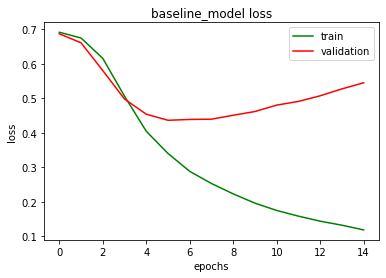

In [40]:
# Visualization of the training process on the loss function 

plt.plot(history.history["loss"], color="green")
plt.plot(history.history["val_loss"], color="r")
plt.title('baseline_model loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

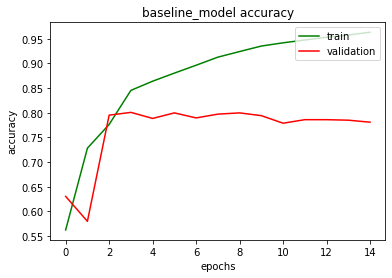

In [41]:
# Visualization of the training process on the accuracy function 

plt.plot(history.history["accuracy"], color="green")
plt.plot(history.history["val_accuracy"], color="r")
plt.title('baseline_model accuracy')
plt.legend(['train', 'validation'], loc='upper right')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

In [42]:
# Accuracy scores on training and validation data

print("The average score of baseline_model accuracy on training data is : {}".format(np.mean(history.history['accuracy'])))
print("The average score of baseline_model accuracy on validation data is : {}".format(np.mean(history.history['val_accuracy'])))
baseline_model_accuracy = np.mean(history.history['accuracy'])
baseline_model_val_accuracy = np.mean(history.history['val_accuracy'])

The average score of baseline_model accuracy on training data is : 0.8724637707074483
The average score of baseline_model accuracy on validation data is : 0.7660890181859334


## > SimpleRNN model
---

In [43]:
# Create a SimpleRNN model

embedding_dim=16 # Dimensionality of the space representation 

vocab_size = tokenizer.num_words # Number of words in the vocabulary
simpleRNN_model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), # The embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  tf.keras.layers.Dropout(0.2),
  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
  tf.keras.layers.Dropout(0.2),
  SimpleRNN(units=32, return_sequences=False), # returns the last output
  tf.keras.layers.Dropout(0.2),
  Dense(16, activation='relu'), # Dense layer
  Dense(1, activation="sigmoid") # Prediction layer
])

simpleRNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          5184      
                                                                 
 dropout_3 (Dropout)         (None, None, 64)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)               

In [44]:
# Compile the model

simpleRNN_model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

In [45]:
# Train the model

history = simpleRNN_model.fit(
    train,
    validation_data = valid,
    epochs = 15
)

Epoch 1/15
72/72 [==============================] - 5s 29ms/step - loss: 0.6888 - accuracy: 0.5512 - precision_1: 0.5534 - recall_1: 0.5457 - val_loss: 0.6318 - val_accuracy: 0.6488 - val_precision_1: 0.6948 - val_recall_1: 0.5231
Epoch 2/15
72/72 [==============================] - 1s 20ms/step - loss: 0.5123 - accuracy: 0.7573 - precision_1: 0.7938 - recall_1: 0.6973 - val_loss: 0.5155 - val_accuracy: 0.7538 - val_precision_1: 0.7777 - val_recall_1: 0.7067
Epoch 3/15
72/72 [==============================] - 2s 21ms/step - loss: 0.2975 - accuracy: 0.8822 - precision_1: 0.9130 - recall_1: 0.8458 - val_loss: 0.5815 - val_accuracy: 0.7365 - val_precision_1: 0.7495 - val_recall_1: 0.7056
Epoch 4/15
72/72 [==============================] - 2s 21ms/step - loss: 0.1783 - accuracy: 0.9360 - precision_1: 0.9517 - recall_1: 0.9190 - val_loss: 0.7198 - val_accuracy: 0.7436 - val_precision_1: 0.7995 - val_recall_1: 0.6462
Epoch 5/15
72/72 [==============================] - 2s 22ms/step - loss: 0.1

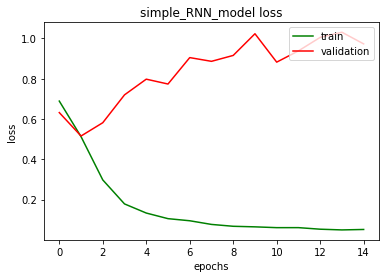

In [46]:
# Visualization of the training process on the loss function 

plt.plot(history.history["loss"], color="green")
plt.plot(history.history["val_loss"], color="r")
plt.title('simple_RNN_model loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

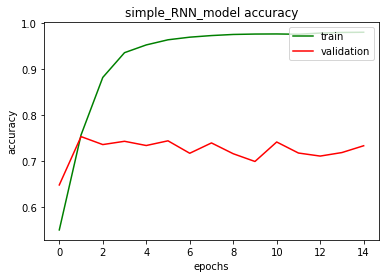

In [47]:
# Visualization of the training process on the accuracy function 

plt.plot(history.history["accuracy"], color="green")
plt.plot(history.history["val_accuracy"], color="r")
plt.title('simple_RNN_model accuracy')
plt.legend(['train', 'validation'], loc='upper right')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

In [48]:
# Accuracy scores on training and validation data

print("The average score of simple_RNN_model accuracy on training data is : {}".format(np.mean(history.history['accuracy'])))
print("The average score of simple_RNN_model accuracy on validation data is : {}".format(np.mean(history.history['val_accuracy'])))
simple_RNN_model_accuracy = np.mean(history.history['accuracy'])
simple_RNN_model_val_accuracy = np.mean(history.history['val_accuracy'])

The average score of simple_RNN_model accuracy on training data is : 0.9219721794128418
The average score of simple_RNN_model accuracy on validation data is : 0.7240570902824401


## > GRU model
---

In [49]:
# Create a SimpleRNN model

embedding_dim=16 # Dimensionality of the space representation 

vocab_size = tokenizer.num_words # Number of words in the vocabulary
GRU_model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), # The embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  tf.keras.layers.Dropout(0.2),
  GRU(units=64, return_sequences=True), # maintains the sequential nature
  tf.keras.layers.Dropout(0.2),
  GRU(units=32, return_sequences=False), # returns the last output
  tf.keras.layers.Dropout(0.2),
  Dense(16, activation='relu'), # Dense layer
  Dense(1, activation="sigmoid") # Prediction layer
])

GRU_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout_5 (Dropout)         (None, None, 16)          0         
                                                                 
 gru (GRU)                   (None, None, 64)          15744     
                                                                 
 dropout_6 (Dropout)         (None, None, 64)          0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)               

In [50]:
# Compile the model

GRU_model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

In [51]:
# Train the model

history = GRU_model.fit(
    train,
    validation_data = valid,
    epochs = 15
)

Epoch 1/15
72/72 [==============================] - 9s 59ms/step - loss: 0.6935 - accuracy: 0.5010 - precision_2: 0.5033 - recall_2: 0.3994 - val_loss: 0.6932 - val_accuracy: 0.4969 - val_precision_2: 0.4969 - val_recall_2: 1.0000
Epoch 2/15
72/72 [==============================] - 3s 41ms/step - loss: 0.6933 - accuracy: 0.4929 - precision_2: 0.4960 - recall_2: 0.6812 - val_loss: 0.6932 - val_accuracy: 0.4969 - val_precision_2: 0.4969 - val_recall_2: 1.0000
Epoch 3/15
72/72 [==============================] - 3s 37ms/step - loss: 0.6933 - accuracy: 0.5008 - precision_2: 0.5028 - recall_2: 0.4268 - val_loss: 0.6931 - val_accuracy: 0.4969 - val_precision_2: 0.4969 - val_recall_2: 1.0000
Epoch 4/15
72/72 [==============================] - 3s 38ms/step - loss: 0.5544 - accuracy: 0.7094 - precision_2: 0.7162 - recall_2: 0.6969 - val_loss: 0.5677 - val_accuracy: 0.7023 - val_precision_2: 0.6432 - val_recall_2: 0.9005
Epoch 5/15
72/72 [==============================] - 3s 38ms/step - loss: 0.3

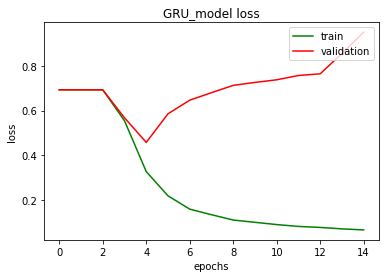

In [52]:
# Visualization of the training process on the loss function 

plt.plot(history.history["loss"], color="green")
plt.plot(history.history["val_loss"], color="r")
plt.title('GRU_model loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

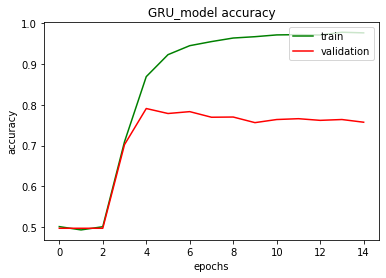

In [53]:
# Visualization of the training process on the accuracy function 

plt.plot(history.history["accuracy"], color="green")
plt.plot(history.history["val_accuracy"], color="r")
plt.title('GRU_model accuracy')
plt.legend(['train', 'validation'], loc='upper right')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

In [54]:
# Accuracy scores on training and validation data

print("The average score of GRU_model accuracy on training data is : {}".format(np.mean(history.history['accuracy'])))
print("The average score of GRU_model accuracy on validation data is : {}".format(np.mean(history.history['val_accuracy'])))
GRU_model_accuracy = np.mean(history.history['accuracy'])
GRU_model_val_accuracy = np.mean(history.history['val_accuracy'])

The average score of GRU_model accuracy on training data is : 0.8466826856136322
The average score of GRU_model accuracy on validation data is : 0.7103975594043732


## > LSTM model
---

In [55]:
# Create a LSTM model

embedding_dim=16 # Dimensionality of the space representation 

vocab_size = tokenizer.num_words # Number of words in the vocabulary
LSTM_model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), # The embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  tf.keras.layers.Dropout(0.2),
  LSTM(units=64, return_sequences=True), # maintains the sequential nature
  tf.keras.layers.Dropout(0.2),
  LSTM(units=32, return_sequences=False), # returns the last output
  tf.keras.layers.Dropout(0.2),
  Dense(16, activation='relu'), # Dense layer
  Dense(1, activation="sigmoid") # Prediction layer
])

LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout_8 (Dropout)         (None, None, 16)          0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          20736     
                                                                 
 dropout_9 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)               

In [56]:
# Compile the model

LSTM_model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', 
             tf.keras.metrics.TruePositives(name='tp'),
             tf.keras.metrics.FalsePositives(name='fp'),
             tf.keras.metrics.TrueNegatives(name='tn'),
             tf.keras.metrics.FalseNegatives(name='fn'),
             tf.keras.metrics.Precision(), 
             tf.keras.metrics.Recall()]
    )

In [57]:
# Train the model

history = LSTM_model.fit(
    train,
    validation_data = valid,
    epochs = 15
)

Epoch 1/15
72/72 [==============================] - 10s 63ms/step - loss: 0.6629 - accuracy: 0.5792 - tp: 738.0000 - fp: 368.0000 - tn: 1913.0000 - fn: 1558.0000 - precision_3: 0.6673 - recall_3: 0.3214 - val_loss: 0.5225 - val_accuracy: 0.7345 - val_tp: 506.0000 - val_fp: 52.0000 - val_tn: 935.0000 - val_fn: 469.0000 - val_precision_3: 0.9068 - val_recall_3: 0.5190
Epoch 2/15
72/72 [==============================] - 3s 39ms/step - loss: 0.4070 - accuracy: 0.8230 - tp: 1749.0000 - fp: 263.0000 - tn: 2018.0000 - fn: 547.0000 - precision_3: 0.8693 - recall_3: 0.7618 - val_loss: 0.4556 - val_accuracy: 0.7854 - val_tp: 721.0000 - val_fp: 167.0000 - val_tn: 820.0000 - val_fn: 254.0000 - val_precision_3: 0.8119 - val_recall_3: 0.7395
Epoch 3/15
72/72 [==============================] - 3s 39ms/step - loss: 0.2547 - accuracy: 0.9002 - tp: 2020.0000 - fp: 181.0000 - tn: 2100.0000 - fn: 276.0000 - precision_3: 0.9178 - recall_3: 0.8798 - val_loss: 0.5245 - val_accuracy: 0.7712 - val_tp: 706.0000

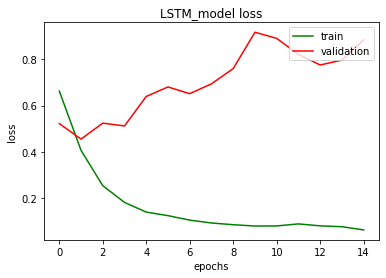

In [58]:
# Visualization of the training process on the loss function 

plt.plot(history.history["loss"], color="green")
plt.plot(history.history["val_loss"], color="r")
plt.title('LSTM_model loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

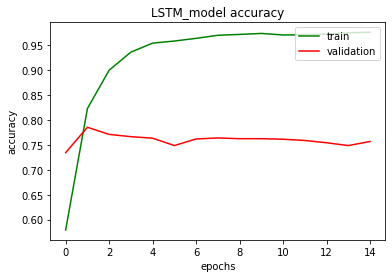

In [59]:
# Visualization of the training process on the accuracy function 

plt.plot(history.history["accuracy"], color="green")
plt.plot(history.history["val_accuracy"], color="r")
plt.title('LSTM_model accuracy')
plt.legend(['train', 'validation'], loc='upper right')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

In [60]:
# Accuracy scores on training and validation data

print("The average score of LSTM_model accuracy on training data is : {}".format(np.mean(history.history['accuracy'])))
print("The average score of LSTM_model accuracy on validation data is : {}".format(np.mean(history.history['val_accuracy'])))
LSTM_model_accuracy = np.mean(history.history['accuracy'])
LSTM_model_val_accuracy = np.mean(history.history['val_accuracy'])

The average score of LSTM_model accuracy on training data is : 0.9266040325164795
The average score of LSTM_model accuracy on validation data is : 0.7600747505823772


In [61]:
# Synthesis of accuracy scores of the differents models

models_recap = pd.DataFrame([[baseline_model_accuracy,baseline_model_val_accuracy,simple_RNN_model_accuracy,simple_RNN_model_val_accuracy,GRU_model_accuracy,GRU_model_val_accuracy,LSTM_model_accuracy,LSTM_model_val_accuracy]],
                            columns = ["baseline_model_accuracy","baseline_model_val_accuracy","simple_RNN_model_accuracy","simple_RNN_model_val_accuracy","GRU_model_accuracy","GRU_model_val_accuracy","LSTM_model_accuracy","LSTM_model_val_accuracy"],
                            index = ["Accuracy and validation's accuracy for the differents models"])

In [62]:
models_recap.T

,Accuracy and validation's accuracy for the differents models
baseline_model_accuracy,0.872464
baseline_model_val_accuracy,0.766089
simple_RNN_model_accuracy,0.921972
simple_RNN_model_val_accuracy,0.724057
GRU_model_accuracy,0.846683
GRU_model_val_accuracy,0.710398
LSTM_model_accuracy,0.926604
LSTM_model_val_accuracy,0.760075


In [63]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'tp', 'fp', 'tn', 'fn', 'precision_3', 'recall_3', 'val_loss', 'val_accuracy', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_precision_3', 'val_recall_3'])

In [64]:
# Confusion matrix of LSTM model

tp=np.mean(history.history['val_tp'])
fp=np.mean(history.history['val_fp'])
tn=np.mean(history.history['val_tn'])
fn=np.mean(history.history['val_fn'])
cm= np.array([[tn,fp],[fn,tp]])
cm


array([[824.53333333, 162.46666667],
       [308.26666667, 666.73333333]])

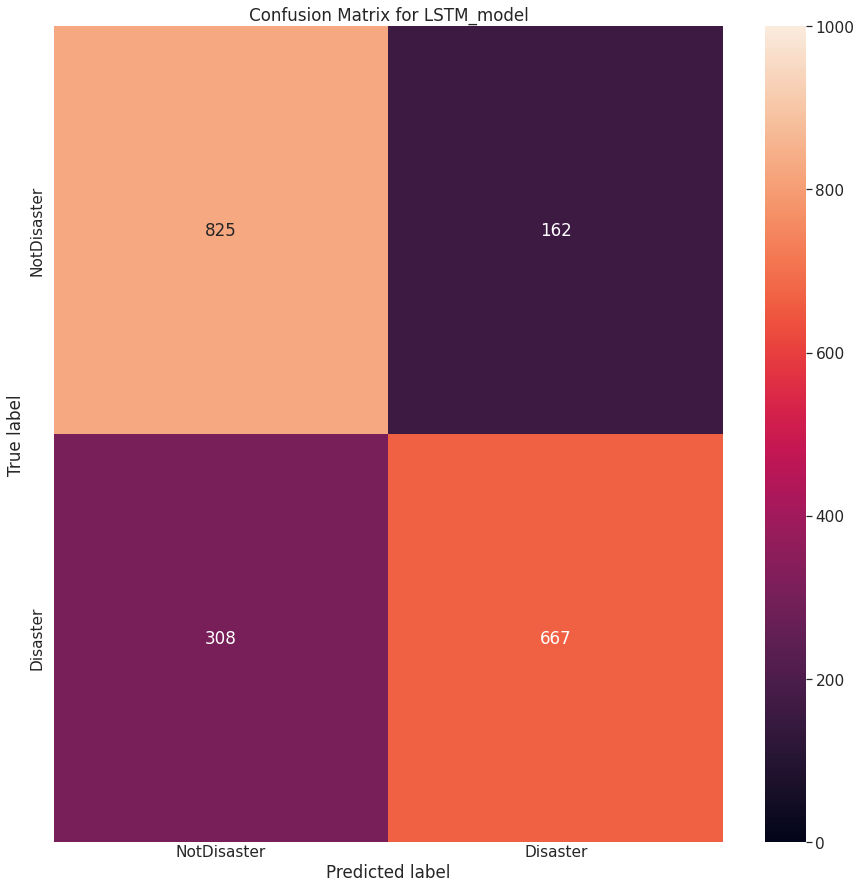

In [65]:
# LSTM confusion matrix - Values

plt.figure(figsize=(15,15))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True,vmin=0.0, vmax=1000.0, fmt='.0f') # font size
plt.yticks([0.5,1.5], ['NotDisaster', 'Disaster'],va='center')
plt.ylabel('True label')
plt.xticks([0.5,1.5], ['NotDisaster', 'Disaster'],va='center')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix for LSTM_model")
plt.show()

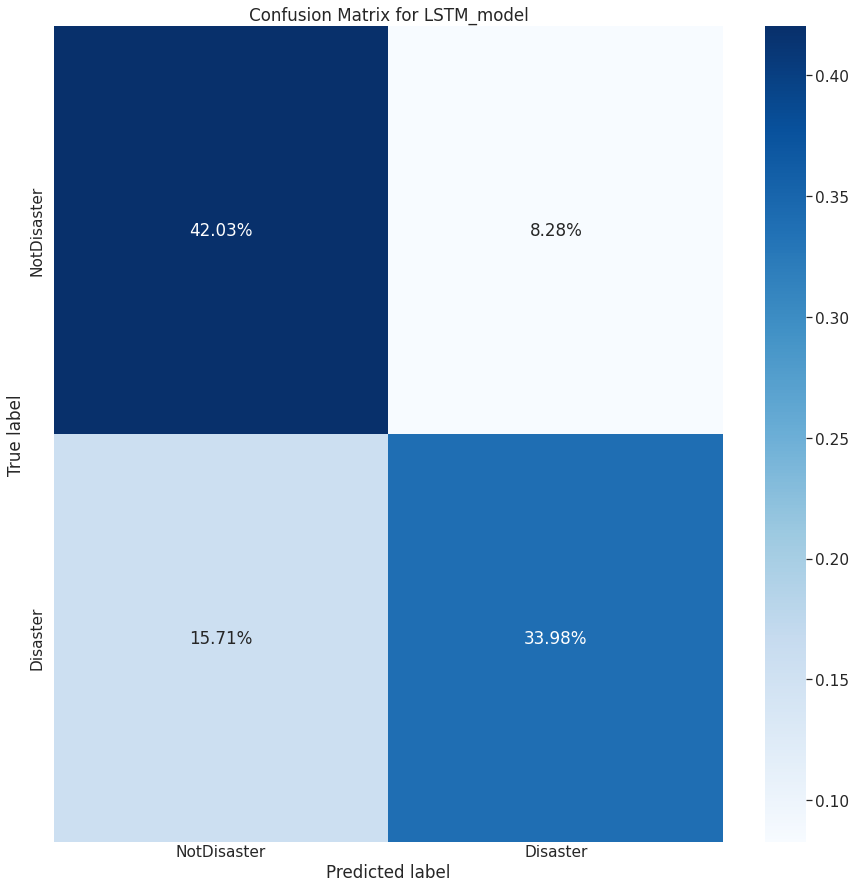

In [66]:
# LSTM confusion matrix - Percentage

plt.figure(figsize=(15,15))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.yticks([0.5,1.5], ['NotDisaster', 'Disaster'],va='center')
plt.ylabel('True label')
plt.xticks([0.5,1.5], ['NotDisaster', 'Disaster'],va='center')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix for LSTM_model")
plt.show()

# **Prediction and submission**

---


## > Preprocessing Test dataset
---

In [67]:
# Drop useless columns from Test dataset : locations and keywords
new_test = test.drop(["keyword", "location"], axis = 1)

In [68]:
# Text cleaning 
new_test['text_clean'] = new_test['text'].str.lower()
new_test['text_clean'] = new_test['text_clean'].str.replace('(@[a-z]+)\w+',' ')
new_test['text_clean'] = new_test['text_clean'].str.replace('(http\S+)', ' ')
new_test['text_clean'] = new_test['text_clean'].str.replace('([^a-z \t])',' ')
new_test['text_clean'] = new_test['text_clean'].str.replace(' +',' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [69]:
# Tokenize the cleaned document
tokenized_doc = new_test["text_clean"].fillna('').apply(lambda x : nlp(x))

In [70]:
# Remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x : [token.lemma_ for token in x if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)])
tokenized_doc

0                          [happen, terrible, car, crash]
1         [hear, earthquake, different, city, stay, safe]
2       [forest, fire, spot, pond, geese, flee, street...
3               [apocalypse, lighting, spokane, wildfire]
4                [typhoon, soudelor, kill, china, taiwan]
                              ...                        
3258    [earthquake, safety, los, angeles, safety, fas...
3259    [storm, ri, bad, hurricane, city, amp, hard, h...
3260                   [green, line, derailment, chicago]
3261       [meg, issue, hazardous, weather, outlook, hwo]
3262    [ , cityofcalgary, activate, municipal, emerge...
Name: text_clean, Length: 3263, dtype: object

In [71]:
# Add a clean token column
new_test["clean_token"] = [" ".join(x) for x in tokenized_doc]

In [72]:
# Removing additional words

remove_words = ['like', 'would', 'amp']

def token_cleaning(data):
    return ' '.join(i for i in data.split() if i not in remove_words)

new_test["clean_token"] = new_test["clean_token"].apply(token_cleaning)

In [73]:
# Encoding 
new_test["token_encoded"] = tokenizer.texts_to_sequences(new_test["text_clean"])
new_test["len_clean_token"] = new_test["token_encoded"].apply(lambda x: len(x))
new_test = new_test[new_test["len_clean_token"]!=0]

In [74]:
new_test

,id,text,text_clean,clean_token,token_encoded,len_clean_token
0,0,Just happened a terrible car crash,just happened a terrible car crash,happen terrible car crash,"[1732, 37, 12]",3
1,2,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...,hear earthquake different city stay safe,"[171, 1028, 367, 1020]",4
2,3,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,forest fire spot pond geese flee street save,"[102, 3, 517, 2352, 385, 95]",6
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,apocalypse lighting spokane wildfire,"[377, 5615]",2
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills in china and taiwan,typhoon soudelor kill china taiwan,"[129, 449, 261, 850]",4
...,...,...,...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles safety fasteners...,earthquake safety los angeles safety fastener ...,"[171, 843, 2217, 2218, 843]",5
3259,10865,Storm in RI worse than last hurricane. My city...,storm in ri worse than last hurricane my city ...,storm ri bad hurricane city hard hit yard look...,"[27, 5568, 220, 106, 131, 5569, 530, 299]",8
3260,10868,Green Line derailment in Chicago http://t.co/U...,green line derailment in chicago,green line derailment chicago,"[700, 361, 219, 866]",4
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issues hazardous weather outlook hwo,meg issue hazardous weather outlook hwo,"[4288, 320, 167, 1174, 1283]",5


In [75]:
new_test.shape

(3236, 6)

In [76]:
# Padding
new_test_token_pad = tf.keras.preprocessing.sequence.pad_sequences(new_test["token_encoded"], padding = "post")

In [77]:
new_test_token_pad

array([[1732,   37,   12, ...,    0,    0,    0],
       [ 171, 1028,  367, ...,    0,    0,    0],
       [ 102,    3,  517, ...,    0,    0,    0],
       ...,
       [ 700,  361,  219, ...,    0,    0,    0],
       [4288,  320,  167, ...,    0,    0,    0],
       [1093,   18,   66, ...,    0,    0,    0]], dtype=int32)

In [78]:
# Prediction 
test_predict = LSTM_model.predict(new_test_token_pad).round().astype(int)

In [79]:
test_predict

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [80]:
# Submission
submission = pd.DataFrame({'id':new_test['id'],'target':test_predict.ravel()})

In [81]:
submission.head(25)

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
5,12,1
6,21,1
7,22,0
8,27,0
9,29,0


In [82]:
submission['target'].value_counts()

0    1886
1    1350
Name: target, dtype: int64

In [83]:
submission.to_csv('./submission.csv', sep=',', encoding='utf-8', index = False)